## MNIST CNN

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

### Data

In [3]:
path = untar_data(URLs.MNIST)

In [4]:
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/mnist_png/testing'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_png/training')]

In [5]:
# PIL convert mode "L" means translating a color image to black and white
# Reference: https://pillow.readthedocs.io/en/3.1.x/handbook/concepts.html#concept-modes
il = ImageItemList.from_folder(path, convert_mode='L')

In [11]:
il.items[0]

PosixPath('/home/ubuntu/.fastai/data/mnist_png/testing/1/4010.png')

In [12]:
defaults.cmap = 'binary'

In [13]:
il

ImageItemList (70000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /home/ubuntu/.fastai/data/mnist_png

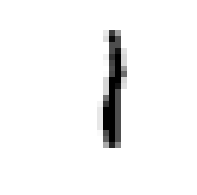

In [27]:
il[0].show()

In [28]:
sd = il.split_by_folder(train='training', valid='testing')

In [29]:
# Sanity check
type(sd)

fastai.data_block.ItemLists

In [30]:
sd

ItemLists;

Train: ImageItemList (60000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /home/ubuntu/.fastai/data/mnist_png;

Valid: ImageItemList (10000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /home/ubuntu/.fastai/data/mnist_png;

Test: None

In [31]:
(path / 'training').ls()

[PosixPath('/home/ubuntu/.fastai/data/mnist_png/training/1'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_png/training/8'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_png/training/9'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_png/training/6'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_png/training/7'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_png/training/2'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_png/training/0'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_png/training/3'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_png/training/4'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_png/training/5')]

In [32]:
ll = sd.label_from_folder()

In [34]:
ll

LabelLists;

Train: LabelList
y: CategoryList (60000 items)
[Category 1, Category 1, Category 1, Category 1, Category 1]...
Path: /home/ubuntu/.fastai/data/mnist_png
x: ImageItemList (60000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /home/ubuntu/.fastai/data/mnist_png;

Valid: LabelList
y: CategoryList (10000 items)
[Category 1, Category 1, Category 1, Category 1, Category 1]...
Path: /home/ubuntu/.fastai/data/mnist_png
x: ImageItemList (10000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /home/ubuntu/.fastai/data/mnist_png;

Test: None

In [37]:
# Sanity check
type(ll.train), type(ll.train[0])

(fastai.data_block.LabelList, tuple)

In [38]:
x, y = ll.train[0]

In [40]:
# Sanity check
type(x), type(y)

(fastai.vision.image.Image, fastai.core.Category)

1 torch.Size([1, 28, 28])


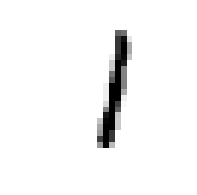

In [41]:
x.show()
print(y, x.shape)

In [42]:
# first list is for train set, second empty list is for test set
# What does the star operator mean? unpack the list
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], []) # pad and crop. crop size 28px, pad mode 'zeros' (default relection)

In [43]:
ll = ll.transform(tfms)

In [45]:
bs = 128

What is DataBunch? From lesson 1:

a general fastai concept for your data, and from there, there are subclasses for particular applications like `ImageDataBunch`.
dataset (i.e. self.train) -> dataloader (self.train_dl, self.train_ds)

In [46]:
# not using imagenet_stats because not using pretrained model
data = ll.databunch(bs=bs).normalize()

In [50]:
doc(ll.databunch)

In [47]:
# Sanity check
type(data)

fastai.vision.data.ImageDataBunch

In [53]:
x, y = data.train_ds[0]

1


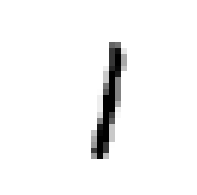

In [56]:
x.show()
print(y)

In [57]:
# Sanity check
type(data.train_ds[0][0])

fastai.vision.image.Image

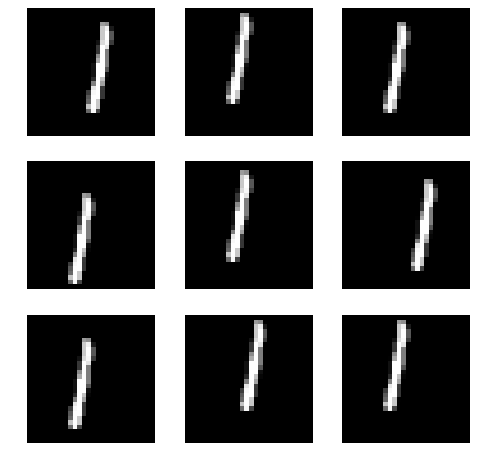

In [58]:
def _plot(i, j, ax): data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8,8))

In [61]:
doc(data.one_batch)
# Get one batch from the data loader of `ds_type`. Optionally `detach` and `denorm`. Returns a Collection[Tensor]
# detach means move tensor from GPU to CPU.

In [62]:
xb, yb = data.one_batch()
xb.shape, yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

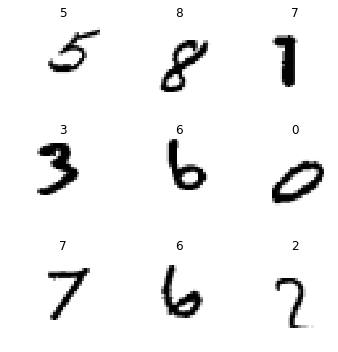

In [63]:
data.show_batch(rows=3, figsize=(5,5))

### Basic CNN with batchnorm

In [64]:
# ni is num input
# nf is num filter
def conv(ni, nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [65]:
# PyTorch sequential container
model = nn.Sequential(
    conv(1, 8), # 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    
    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    
    Flatten()     # remove (1,1) grid. 1 is unit axis
)

In [66]:
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

In [67]:
# Sanity check
type(learn)

fastai.basic_train.Learner

In [69]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [128, 8, 14, 14]     80         True      
______________________________________________________________________
BatchNorm2d          [128, 8, 14, 14]     16         True      
______________________________________________________________________
ReLU                 [128, 8, 14, 14]     0          False     
______________________________________________________________________
Conv2d               [128, 16, 7, 7]      1168       True      
______________________________________________________________________
BatchNorm2d          [128, 16, 7, 7]      32         True      
______________________________________________________________________
ReLU                 [128, 16, 7, 7]      0          False     
______________________________________________________________________
Conv2d               [128, 32, 4, 4]      4640       True      
______________________________________________________________

In [70]:
xb = xb.cuda()

In [71]:
model(xb).shape

torch.Size([128, 10])

In [72]:
learn.lr_find(end_lr=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


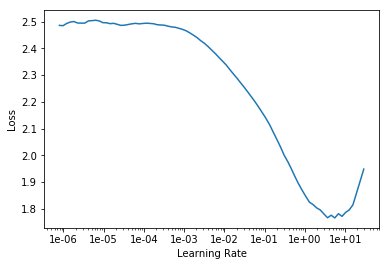

In [73]:
learn.recorder.plot()

In [74]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy
1,0.222742,0.537284,0.842800
2,0.136951,0.081584,0.975300
3,0.075597,0.041812,0.986900


### Refactor

In [76]:
def conv2(ni, nf): return conv_layer(ni, nf, stride=2)

In [78]:
model = nn.Sequential(
    conv(1, 8),     # 14
    conv(8, 16),    # 7
    conv(16, 32),   # 4
    conv(32, 16),   # 2
    conv(16, 10),   # 1
    Flatten()       # remove (1,1) grid
)

In [79]:
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

In [80]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy
1,1.493621,1.083352,0.668000
2,1.679995,0.914248,0.715200
3,13845.543945,637.649170,0.097400
4,3.488301,1.606864,0.502200
5,1.451810,0.885681,0.717800
6,1.329285,0.821450,0.767700
7,1.520882,1.571306,0.486200
8,1.294403,0.784840,0.787100
9,1.193693,0.783441,0.774000
10,1.110655,0.729030,0.797700


### Resnet-ish

In [81]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf, nf)
        self.conv2 = conv_layer(nf, nf)
    
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [82]:
help(res_block)

Help on function res_block in module fastai.layers:

res_block(nf, dense:bool=False, norm_type:Union[fastai.layers.NormType, NoneType]=<NormType.Batch: 1>, bottle:bool=False, **kwargs)
    Resnet block of `nf` features.



In [83]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [84]:
def conv_and_res(ni, nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [85]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [86]:
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

In [87]:
learn.lr_find(end_lr=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


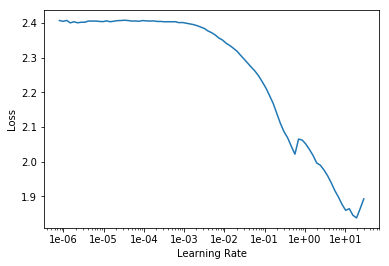

In [88]:
learn.recorder.plot()

In [89]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy
1,0.264350,0.197537,0.953900
2,0.141571,0.100534,0.969200
3,0.110794,0.221931,0.936400
4,0.095346,0.106152,0.968800
5,0.072221,0.039760,0.987500
6,0.063750,0.058403,0.981500
7,0.052838,0.044521,0.987300
8,0.042057,0.026808,0.990600
9,0.037357,0.034371,0.990200
10,0.028304,0.018587,0.994500


In [90]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [128, 8, 14, 14]     72         True      
______________________________________________________________________
ReLU                 [128, 8, 14, 14]     0          False     
______________________________________________________________________
BatchNorm2d          [128, 8, 14, 14]     16         True      
______________________________________________________________________
Conv2d               [128, 8, 14, 14]     576        True      
______________________________________________________________________
ReLU                 [128, 8, 14, 14]     0          False     
______________________________________________________________________
BatchNorm2d          [128, 8, 14, 14]     16         True      
______________________________________________________________________
Conv2d               [128, 8, 14, 14]     576        True      
______________________________________________________________

## fin